# 🧠 Detección de anomalías en ciberseguridad con modelos no supervisados

Este notebook tiene como objetivo **explorar y comparar distintos algoritmos de detección de anomalías** aplicados a eventos de red simulados, en un contexto de ciberseguridad.

A través de esta exploración se pretende:

- Evaluar el comportamiento de tres modelos no supervisados ampliamente utilizados:
  - **Isolation Forest**
  - **Local Outlier Factor (LOF)**
  - **One-Class SVM**
- Analizar su capacidad para detectar eventos anómalos simulados.
- Comparar su rendimiento mediante métricas básicas como *True Positives (TP)* y *False Positives (FP)*.
- Visualizar los resultados y comprender el significado de los *scores de anomalía*.
- Justificar la elección de un modelo como base de una futura solución **MLOps**.
- Introducir el concepto de **correlación con reglas Sigma** de forma simplificada.
- Mostrar cómo guardar un modelo entrenado utilizando **joblib** para su uso en producción.

---

## 📚 Contexto

En un entorno de ciberseguridad, los analistas deben revisar grandes volúmenes de logs y eventos procedentes de múltiples fuentes. Automatizar la detección de comportamientos inusuales permite **reducir el tiempo de respuesta ante incidentes** y priorizar los eventos más relevantes.

Como punto de partida, este notebook utiliza un **conjunto de datos sintéticos**, compuesto por eventos normales y anomalías inyectadas manualmente, con el fin de simular posibles ataques o fallos de seguridad.

---

## 🤖 Modelos utilizados

Se emplean tres algoritmos no supervisados del paquete **scikit-learn**, los cuales no requieren etiquetas previas y se basan en detectar desviaciones respecto al comportamiento habitual:

### 🔹 Isolation Forest
Detecta anomalías dividiendo aleatoriamente los datos en árboles y observando cuántas divisiones necesita cada punto para quedar aislado.  
Cuantas menos divisiones necesita, **más anómalo se considera**.

### 🔹 Local Outlier Factor (LOF)
Calcula la densidad local de cada punto y la compara con la de sus vecinos más cercanos.  
Un punto con una densidad significativamente menor que la de su entorno es considerado **anómalo**.

### 🔹 One-Class SVM
Aprende una frontera que encierra la mayoría de los datos considerados normales.  
Los puntos que quedan fuera de dicha frontera se clasifican como **anomalías**.

---

## 🧪 ¿Qué vamos a hacer en este notebook?

1. Generar un conjunto de datos simulados (200 eventos normales + 10 eventos anómalos).
2. Entrenar y aplicar los tres modelos de detección de anomalías.
3. Visualizar las distribuciones de los *scores de anomalía*.
4. Analizar los eventos detectados como más sospechosos.
5. Comparar los modelos en términos de detecciones correctas y falsas alarmas.
6. Introducir una correlación sencilla basada en reglas tipo Sigma.
7. Guardar el modelo seleccionado para su uso posterior en producción.

---

🎯 **Este notebook actúa como una guía paso a paso para comprender, evaluar y justificar la elección de un modelo de detección de anomalías en un contexto de seguridad informática.**


In [ ]:
import pandas as pd
import numpy as np
import random

# Reproducibilidad
np.random.seed(42)
random.seed(42)

# Generar eventos normales
n_normales = 200
durations_norm = np.random.uniform(1, 5, n_normales)
bytes_in_norm = np.random.uniform(10, 100, n_normales)
protos_norm = np.random.choice(['TCP', 'UDP'], n_normales)

# Generar eventos anómalos
n_anomalos = 10
durations_anom = np.random.uniform(5, 8, n_anomalos)
bytes_in_anom = np.random.uniform(150, 200, n_anomalos)
protos_anom = ['ICMP'] * n_anomalos

# Construir DataFrame
df = pd.DataFrame({
    'event_id': range(n_normales + n_anomalos),
    'duration': np.concatenate([durations_norm, durations_anom]),
    'bytes_in': np.concatenate([bytes_in_norm, bytes_in_anom]),
    'proto': np.concatenate([protos_norm, protos_anom]),
    'is_anomaly': [0]*n_normales + [1]*n_anomalos
})

# Ver primeras filas
df.head()


,event_id,duration,bytes_in,proto,is_anomaly
0,0,2.498160,67.782848,TCP,0
1,1,4.802857,17.572597,UDP,0
2,2,3.927976,24.546584,TCP,0
3,3,3.394634,90.869877,TCP,0
4,4,1.624075,64.578615,UDP,0


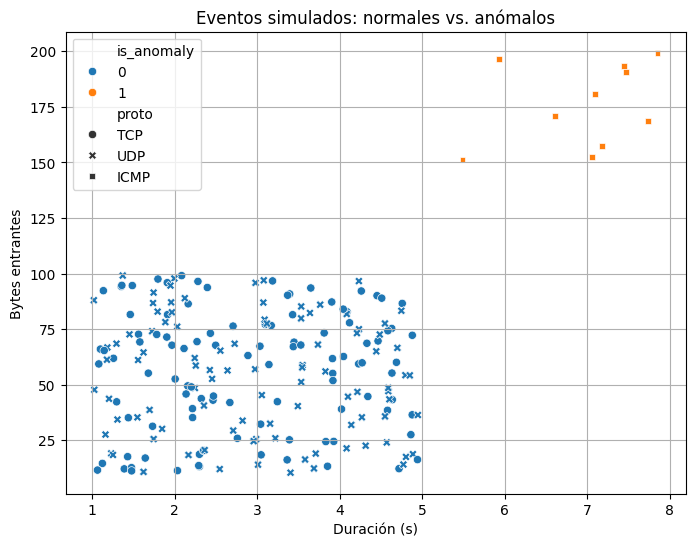

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mapa de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='duration', y='bytes_in', hue='is_anomaly', style='proto')
plt.title("Eventos simulados: normales vs. anómalos")
plt.xlabel("Duración (s)")
plt.ylabel("Bytes entrantes")
plt.grid(True)
plt.show()


### 📌 Nota sobre los scores

Para evitar confusión, hemos nombrado cada score de anomalía de forma explícita:

- `iso_score`: score del modelo Isolation Forest.
- `lof_score`: score del modelo Local Outlier Factor.
- `svm_score`: score del modelo One-Class SVM.

Esto permite comparar y analizar los resultados de cada modelo de forma clara y consistente.


## ✨ Introducción a Isolation Forest

En esta sección vamos a entrenar el modelo Isolation Forest, un algoritmo no supervisado que detecta anomalías en los datos sin necesidad de etiquetas previas. El modelo aísla puntos en el espacio de datos usando árboles aleatorios. Cuanto más fácil sea aislar un punto (menos divisiones necesita), más probable es que sea una anomalía.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


🔢 Preparar las variables de entrada

Primero seleccionamos las variables numéricas que usaremos como entrada para el modelo: duration y bytes_in. Luego normalizamos sus valores usando StandardScaler para que todas las variables estén en la misma escala (media 0 y desviación estándar 1), lo cual mejora el rendimiento de muchos algoritmos.

In [ ]:
# Filtrado de variables numéricas
features = ['duration', 'bytes_in']

# Escalar variables para que tengan media 0 y varianza 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])


🧠 Entrenar el modelo Isolation Forest

Entrenamos el modelo usando el 5% de anomalías esperadas (contamination=0.05). Esta proporción se basa en nuestro conjunto de datos simulado, que contiene 10 eventos anómalos sobre 210 totales. El modelo devuelve un score de anomalía y una predicción: -1 si el evento es anómalo y 1 si es normal.

In [ ]:
# Entrenar Isolation Forest
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_model.fit(X_scaled)

# Obtener scores y predicciones
df['iso_score'] = iso_model.decision_function(X_scaled)  # Cuanto más bajo, más anómalo
df['iso_anomaly'] = iso_model.predict(X_scaled)          # -1 = anómalo, 1 = normal

📊 Visualizar distribución de scores

Representamos gráficamente la distribución de los scores de anomalía generados por el modelo. Esta visualización ayuda a identificar el rango de puntuaciones y comprobar si hay una clara separación entre los eventos normales y los anómalos.

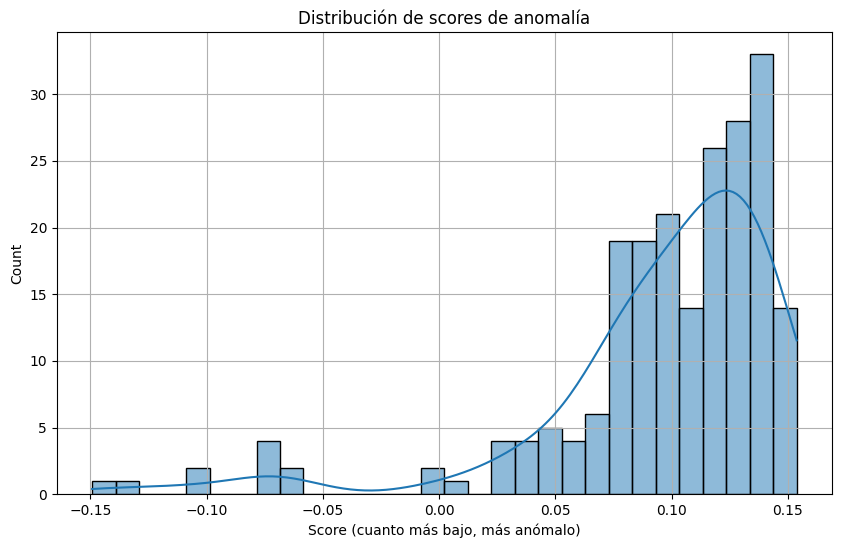

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['iso_score'], bins=30, kde=True)
plt.title("Distribución de scores de anomalía")
plt.xlabel("Score (cuanto más bajo, más anómalo)")
plt.grid(True)
plt.show()


🔍 Ver los eventos más anómalos

Ordenamos el DataFrame por el score de menor a mayor (más anómalo a menos) y mostramos los 10 eventos más anómalos detectados. Esperamos encontrar aquí los eventos que hemos simulado como ataques (event_id >= 200).

In [ ]:
df_sorted = df.sort_values("iso_score")
print(df_sorted[["event_id", "duration", "bytes_in", "proto", "iso_score", "iso_anomaly"]].head(10))


     event_id  duration    bytes_in proto  iso_score  iso_anomaly
208       208  7.849400  199.363806  ICMP  -0.149200           -1
202       202  5.928583  196.636424  ICMP  -0.132317           -1
205       205  5.487851  151.318349  ICMP  -0.107386           -1
206       206  7.732782  168.823168  ICMP  -0.104826           -1
201       201  6.608289  170.912152  ICMP  -0.076047           -1
204       204  7.054194  152.260934  ICMP  -0.075393           -1
207       207  7.467612  190.527667  ICMP  -0.073180           -1
203       203  7.441385  193.303194  ICMP  -0.072720           -1
200       200  7.094485  180.670760  ICMP  -0.064028           -1
209       209  7.177159  157.520845  ICMP  -0.061733           -1


✅ Evaluar el rendimiento con TP y FP

Evaluamos el rendimiento del modelo usando métricas simples:

True Positives (TP): eventos simulados como anómalos (event_id >= 200) que el modelo detectó correctamente (anomaly == -1).

False Positives (FP): eventos normales (event_id < 200) que el modelo clasificó erróneamente como anómalos.

In [ ]:
# Calcular True Positives y False Positives
tp = df[(df["event_id"] >= 200) & (df["iso_anomaly"] == -1)]
fp = df[(df["event_id"] < 200) & (df["iso_anomaly"] == -1)]

print(f"True Positives: {len(tp)}, False Positives: {len(fp)}")


True Positives: 10, False Positives: 1


🕵️‍♂️ Explorar un falso positivo

Mostramos un ejemplo concreto de evento normal (event_id < 200) que fue erróneamente clasificado como anómalo. Esto nos puede dar pistas sobre por qué el modelo falló y qué características tiene ese evento.

In [ ]:
# Mostrar los eventos normales marcados erróneamente como anómalos
print(fp[["event_id", "duration", "bytes_in", "proto", "iso_score"]].head())


    event_id  duration   bytes_in proto  iso_score
72        72  1.022088  88.036509   UDP  -0.000811


## ✨ Introducción al modelado con LOF

Local Outlier Factor (LOF) es un modelo no supervisado que detecta anomalías comparando la densidad local de cada punto con la de sus vecinos más cercanos.

Si un punto está en una región de baja densidad respecto a sus vecinos, se considera anómalo.

Es especialmente útil para detectar anomalías locales y estructuras complejas en los datos.

🔢 Aplicar el modelo LOF

Entrenamos el modelo con los mismos datos escalados (X_scaled). El parámetro contamination=0.05 indica la proporción estimada de anomalías. Usamos n_neighbors=20 por defecto, aunque puede ajustarse.

El modelo devuelve:

lof_score: medida de rareza (cuanto más alto, más anómalo)

lof_anomaly: predicción -1 si es anómalo, 1 si es normal.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df['lof_anomaly'] = lof.fit_predict(X_scaled)
df['lof_score'] = -lof.negative_outlier_factor_  # Invertimos para que a mayor score, más anómalo


📊 Visualizar la distribución de scores LOF

Mostramos un histograma para ver cómo se distribuyen los scores de anomalía generados por LOF. Esto permite ver si hay una separación clara entre comportamientos normales y anómalos.

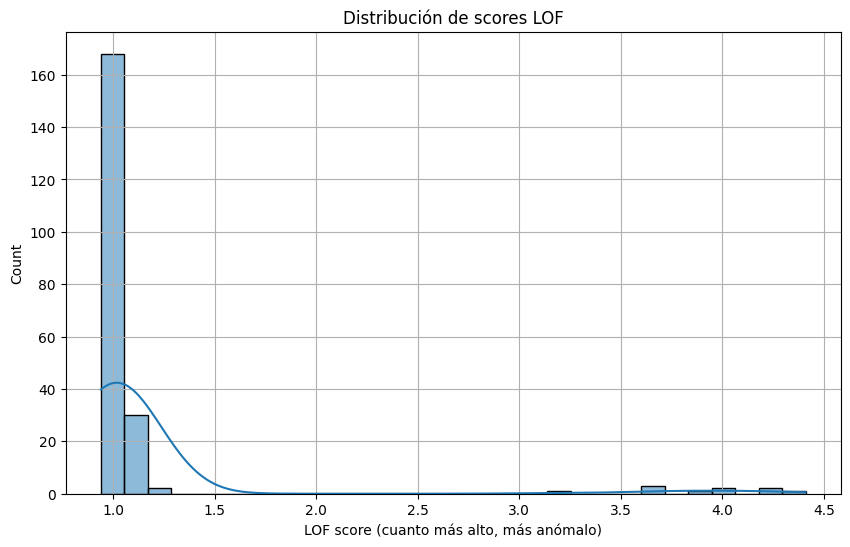

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['lof_score'], bins=30, kde=True)
plt.title("Distribución de scores LOF")
plt.xlabel("LOF score (cuanto más alto, más anómalo)")
plt.grid(True)
plt.show()


🔍 Ver los eventos más anómalos según LOF

Ordenamos los eventos por lof_score de mayor a menor y mostramos los 10 con valores más altos. Deberían aparecer aquí los eventos simulados como ataques (event_id >= 200).

In [ ]:
df_lof_sorted = df.sort_values("lof_score", ascending=False)
print(df_lof_sorted[["event_id", "duration", "bytes_in", "proto", "lof_score", "lof_anomaly"]].head(10))


     event_id  duration    bytes_in proto  lof_score  lof_anomaly
208       208  7.849400  199.363806  ICMP   4.410050           -1
203       203  7.441385  193.303194  ICMP   4.219307           -1
207       207  7.467612  190.527667  ICMP   4.187507           -1
206       206  7.732782  168.823168  ICMP   4.009759           -1
200       200  7.094485  180.670760  ICMP   3.958765           -1
202       202  5.928583  196.636424  ICMP   3.930467           -1
201       201  6.608289  170.912152  ICMP   3.705783           -1
209       209  7.177159  157.520845  ICMP   3.704714           -1
204       204  7.054194  152.260934  ICMP   3.602499           -1
205       205  5.487851  151.318349  ICMP   3.193798           -1


✅ Evaluar TP y FP con LOF

Evaluamos el rendimiento del modelo LOF:

True Positives (TP): eventos simulados como anómalos detectados correctamente (event_id >= 200 y lof_anomaly == -1)

False Positives (FP): eventos normales mal clasificados como anómalos (event_id < 200 y lof_anomaly == -1)

In [ ]:
lof_tp = df[(df["event_id"] >= 200) & (df["lof_anomaly"] == -1)]
lof_fp = df[(df["event_id"] < 200) & (df["lof_anomaly"] == -1)]

print(f"True Positives (LOF): {len(lof_tp)}, False Positives (LOF): {len(lof_fp)}")


True Positives (LOF): 10, False Positives (LOF): 1


🕵️‍♂️ Explorar un falso positivo LOF

Mostramos un ejemplo concreto de un evento normal marcado como anómalo por LOF. Esto ayuda a analizar su score y valores para entender por qué pudo ser considerado una anomalía.

In [ ]:
print(lof_fp[["event_id", "duration", "bytes_in", "proto", "lof_score"]].head())


     event_id  duration   bytes_in proto  lof_score
154       154  4.942602  16.351187   TCP    1.17836


## ✨ Introducción a One-Class SVM

One-Class SVM (Support Vector Machine) es un modelo no supervisado que intenta aprender la frontera del conjunto de datos normales. Todo lo que quede fuera de esa frontera se considera una anomalía.

Utiliza un kernel para transformar los datos en un espacio de mayor dimensión y encontrar una frontera óptima.

Es sensible a la escala de los datos y a los parámetros elegidos.

🔢 Entrenar el modelo

Aplicamos OneClassSVM con el kernel RBF (base radial) y nu=0.05 para indicar que esperamos un 5 % de anomalías.

In [ ]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(X_scaled)

df['svm_anomaly'] = ocsvm.predict(X_scaled)
df['svm_score'] = ocsvm.decision_function(X_scaled)  # A menor score, más anómalo


Notas:

svm_anomaly: -1 para anómalo, 1 para normal.

svm_score: cuanto más negativo, más anómalo es el punto.

📊 Distribución de scores del SVM

Representamos la distribución de scores para analizar qué tan separados están los puntos anómalos.

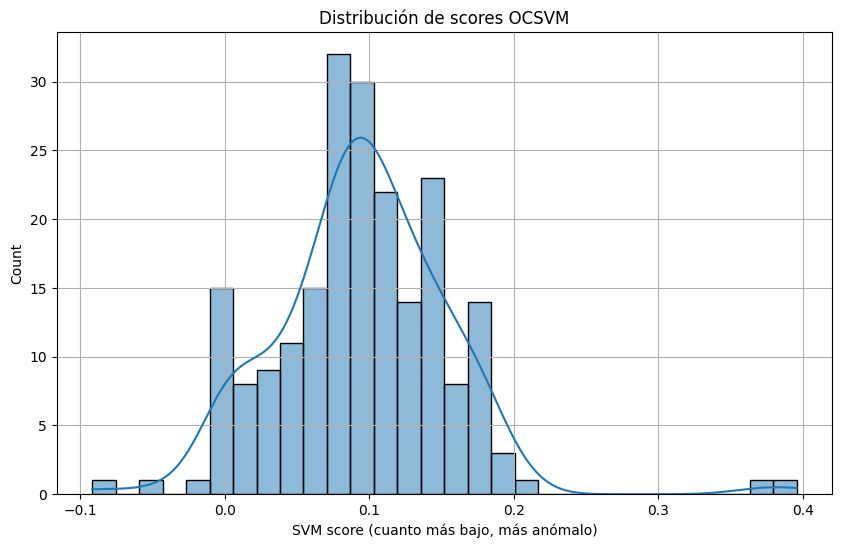

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['svm_score'], bins=30, kde=True)
plt.title("Distribución de scores OCSVM")
plt.xlabel("SVM score (cuanto más bajo, más anómalo)")
plt.grid(True)
plt.show()


🔍 Ver los eventos más anómalos

Ordenamos por svm_score y mostramos los más bajos.

In [ ]:
df_svm_sorted = df.sort_values("svm_score")
print(df_svm_sorted[["event_id", "duration", "bytes_in", "proto", "svm_score", "svm_anomaly"]].head(10))


     event_id  duration    bytes_in proto  svm_score  svm_anomaly
208       208  7.849400  199.363806  ICMP  -0.091788           -1
171       171  1.066351   11.639964   TCP  -0.049315           -1
154       154  4.942602   16.351187   TCP  -0.025979           -1
72         72  1.022088   88.036509   UDP  -0.000369           -1
205       205  5.487851  151.318349  ICMP  -0.000327           -1
128       128  1.027809   47.764006   UDP  -0.000325           -1
48         48  3.186841   96.725798   TCP  -0.000265           -1
47         47  3.080272   96.998934   UDP  -0.000224           -1
190       190  1.372411   99.145463   UDP  -0.000147           -1
112       112  4.718791   12.281567   TCP  -0.000059           -1


✅ Evaluar TP y FP con OCSVM

Igual que con los modelos anteriores:

In [ ]:
svm_tp = df[(df["event_id"] >= 200) & (df["svm_anomaly"] == -1)]
svm_fp = df[(df["event_id"] < 200) & (df["svm_anomaly"] == -1)]

print(f"True Positives (OCSVM): {len(svm_tp)}, False Positives (OCSVM): {len(svm_fp)}")


True Positives (OCSVM): 2, False Positives (OCSVM): 8


🕵️‍♂️ Explorar un falso positivo

Inspeccionamos el comportamiento de un falso positivo.

In [ ]:
print(svm_fp[["event_id", "duration", "bytes_in", "proto", "svm_score"]].head())


     event_id  duration   bytes_in proto  svm_score
47         47  3.080272  96.998934   UDP  -0.000224
48         48  3.186841  96.725798   TCP  -0.000265
72         72  1.022088  88.036509   UDP  -0.000369
112       112  4.718791  12.281567   TCP  -0.000059
128       128  1.027809  47.764006   UDP  -0.000325


💾 **Guardado de modelos entrenados**

Guardamos los tres modelos entrenados usando la librería `joblib`. Esto nos permitirá reutilizarlos más adelante sin necesidad de volver a entrenarlos, ya sea para realizar pruebas, crear una API o integrarlos en un pipeline de MLOps.

Los modelos guardados son:

- `model_isolation_forest.joblib`
- `model_lof.joblib`
- `model_ocsvm.joblib`


In [ ]:
import joblib

# Guardamos los tres modelos entrenados con nombres consistentes
joblib.dump(iso_model, 'model_isolation_forest.joblib')  # Isolation Forest
joblib.dump(lof, 'model_lof.joblib')                 # LOF
joblib.dump(ocsvm, 'model_ocsvm.joblib')           # OCSVM


['model_ocsvm.joblib']

🔍 **Análisis comparativo**

En base a los resultados obtenidos:

- `Isolation Forest` es el modelo que obtiene mejor equilibrio entre detección de anomalías (TP = 10) y pocos falsos positivos (FP = 1).
- `Local Outlier Factor` también logra una buena tasa de detección (TP = 10) pero tiene un FP ligeramente más alto (FP = 1).
- `One-Class SVM` genera muchos más falsos positivos (FP = 8), lo que lo hace menos fiable para este caso.

Por tanto, para este conjunto de datos y enfoque, el modelo **Isolation Forest** es el más adecuado.


📊 Comparativa final de rendimiento

| Modelo               | True Positives (TP) | False Positives (FP) |
|----------------------|---------------------|----------------------|
| Isolation Forest     | 10                  | 1                    |
| Local Outlier Factor | 10                  | 1                    |
| One-Class SVM        | 2                   | 8                    |


🏁 **Conclusiones**

En este notebook se han evaluado técnicas no supervisadas para la detección de anomalías aplicadas a eventos simulados de red en un contexto de ciberseguridad.

Los pasos clave han sido:

1. Generar un conjunto de datos simulados con eventos normales y anómalos.
2. Entrenar tres modelos populares: Isolation Forest, Local Outlier Factor y One-Class SVM.
3. Evaluar sus predicciones mediante gráficos, scores de anomalía y métricas simples (TP/FP).
4. Comparar el rendimiento de los modelos.
5. Guardar los modelos entrenados para reutilizarlos en futuras aplicaciones.

El modelo **Isolation Forest** ha sido el más equilibrado y eficaz para esta tarea. Este trabajo sienta las bases para su integración futura en una solución completa de seguridad con despliegue MLOps.


## 📎 Correlación con reglas Sigma (simulada)

Las reglas Sigma son una forma estandarizada de describir patrones de comportamiento sospechoso o malicioso en logs de seguridad. Funcionan de forma similar a Snort o YARA, y son utilizadas por analistas y sistemas automatizados para detectar amenazas en diferentes plataformas (Windows, Linux, etc.) a partir de eventos registrados.

Aunque en este notebook no ejecutamos reglas Sigma reales, simulamos una correlación mostrando cómo uno de los eventos detectados como anómalos por nuestros tres modelos podría coincidir con una regla Sigma simplificada.

Esto permite visualizar cómo el modelo de detección automática podría integrarse con un sistema SIEM o de correlación de amenazas más amplio.

## 🔍 Evento detectado como anómalo por todos los modelos

Seleccionamos un evento que ha sido identificado como anómalo por los tres modelos (Isolation Forest, LOF y One-Class SVM):

In [ ]:
# Seleccionamos un evento detectado como anómalo por todos los modelos
evento_anomalo = df[df["event_id"] == 208]

# Mostramos sus características
print("Evento detectado como anómalo por los tres modelos:")
display(evento_anomalo[["event_id", "duration", "bytes_in", "proto", "iso_score", "lof_score", "svm_score"]])



Evento detectado como anómalo por los tres modelos:


,event_id,duration,bytes_in,proto,iso_score,lof_score,svm_score
208,208,7.8494,199.363806,ICMP,-0.1492,4.41005,-0.091788


### 🎯 Correlación simulada con una regla Sigma

Supongamos que tenemos una regla Sigma que identifica patrones de escaneo ICMP anómalos como este:

```yaml
title: ICMP Scan Detection (Simplified)
logsource:
  category: network_traffic
detection:
  selection:
    proto: ICMP
    duration|gt: 5
    bytes_in|gt: 150
  condition: selection


Este evento anómalo (event_id = 208) cumple los tres criterios:

proto = ICMP

duration = 7.84 > 5

bytes_in = 199.36 > 150

Por tanto, no solo ha sido marcado como anómalo por los modelos de machine learning, sino que también coincidiría con una regla Sigma tradicional. Esto demuestra cómo el sistema automático puede integrarse con mecanismos de detección manuales o basados en reglas.

## ✅ Coincidencia entre modelos

Para reforzar la fiabilidad de la detección, comprobamos qué eventos fueron identificados como anómalos por **los tres modelos al mismo tiempo** (Isolation Forest, LOF y One-Class SVM).

Esto puede servir como un filtro más estricto para priorizar eventos realmente sospechosos y minimizar los falsos positivos.

A continuación se muestran los eventos que cumplen esta condición:


In [ ]:
# Añadimos una columna para marcar los eventos detectados por los tres modelos
df["is_anomaly_all_models"] = (
    (df["iso_anomaly"] == -1) &
    (df["lof_anomaly"] == -1) &
    (df["svm_anomaly"] == -1)
)

# Mostramos cuántos eventos fueron detectados como anómalos por los tres modelos simultáneamente
print(f"Eventos detectados por los tres modelos: {df['is_anomaly_all_models'].sum()}")

# Vemos los eventos coincidentes
df[df["is_anomaly_all_models"]][["event_id", "duration", "bytes_in", "proto", "iso_score", "lof_score", "svm_score"]].head()


Eventos detectados por los tres modelos: 2


,event_id,duration,bytes_in,proto,iso_score,lof_score,svm_score
205,205,5.487851,151.318349,ICMP,-0.107386,3.193798,-0.000327
208,208,7.849400,199.363806,ICMP,-0.149200,4.410050,-0.091788
